# Load imports and create directories

In [1]:
from ROOT import (TCanvas, TPad, TFile, TPaveLabel, 
                  TPaveText, gROOT, TH1F, TH1D, TLegend, 
                  gStyle, TH2F, TChain, TGraphErrors, TText, gPad, gROOT, TTree)
from array import array
import datetime
import numpy as np

np.random.seed(42)
        
from keras.models import Sequential, Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate, SimpleRNN, GRU, Masking, Lambda, Reshape, Dropout, RNN
from keras.optimizers import Adagrad, SGD, RMSprop, Adam

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU, LSTM, Conv1D, SimpleRNN, Concatenate
from keras import optimizers
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import keras.backend as K
import pickle
#import seaborn as sns

TODAY = datetime.datetime.now().strftime('%Y-%m-%d')

def init_dirs():
    import datetime, os
    for _dir in ["plots", "models"]:
        today_dir = os.path.join(_dir, TODAY)
        if not os.path.isdir(today_dir):
            os.makedirs(today_dir)
            
#init_dirs()
from sklearn import preprocessing

Welcome to JupyROOT 6.14/06


Using TensorFlow backend.


## define features and cuts

In [2]:
# all methods here
MASS_FEATURE_INDEX = 0
def prep_mass(xbtrain, xstrain, norm=None):
    np.random.seed(42)
    new = xbtrain.copy()
    sump = sum(xstrain[:,-1])
    for d in new:
        mass = np.random.choice(xstrain[:,MASS_FEATURE_INDEX], p=1/sump*xstrain[:,-1])
        if norm:
            mass = mass / norm
        d[MASS_FEATURE_INDEX] = mass
    return new

def unison_shuffled_copies(*arr):
    assert all(len(a) for a in arr)
    p = np.random.permutation(len(arr[0]))
    return (a[p] for a in arr)

# Load weights for prescaling (you may or may not need this)

Rescale the samples according to their cross section.

In [3]:
Xsec_dict={5:6.76E-03, 7:5.33E-03, 9:4.40E-03, 11:3.71E-03, 13:3.18E-03, 15:3.59E-03, 17:3.86E-03, 19:4.02E-03, 23:5.81E-03, 27:6.67E-03, 31:6.71E-03, 35:9.60E-03, 39:1.07E-02, 45:7.99E-03, 51:5.20E-03, 57:6.36E-03, 63:8.33E-03, 69:9.77E-03, 75:1.17E-02}

def getweight(xtrain, mass=5):
    totalWt = sum(xtrain[:,-1])
    xtrain[:,-1] = Xsec_dict[mass]*xtrain[:,-1]/totalWt
    return xtrain

def norweight(wt, norm=1000):
    totalWt = sum(wt)
    frac = norm/totalWt
    wt = frac*wt
    return wt

def get_part_feature(xtrain):
    nf = [0,1,2,3,4,5,6,7,8,11,12,13,14,15,16,17,18,19]
    #nf = [20,21,22,23,24,25,26,27,28,31,34,35,36,37,38,39]
    xtrain = xtrain[:,nf]
    return xtrain


# Start training
## setup datasets for training and testing

In [4]:
# Load and sum signal dataset
xb_train = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below120/UnscaledData/train/tree_bkg.npy')
xb_train[:,-1] = norweight(xb_train[:,-1], norm=19000)

xs_train = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below120/UnscaledData/train/tree_{}GeV.npy'.format(5))
xs_train[:,-1] = norweight(xs_train[:,-1])
xs_val = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below120/UnscaledData/Validation/tree_{}GeV.npy'.format(5))
xs_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below120/UnscaledData/test/tree_{}GeV.npy'.format(5))

msamp2 = [7,9,11,13,15,17,19,23,27,31,35,39,45,51,57,63,69,75]
#msamp2 = [7,9,11,13,15,17,19,23,27,31,35,39]
for mass in msamp2:
    ### for signal
    xs_train_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below120/UnscaledData/train/tree_{}GeV.npy'.format(mass))
    xs_train_add[:,-1] = norweight(xs_train_add[:,-1])
    xs_train = np.concatenate((xs_train,xs_train_add))
    xs_val_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below120/UnscaledData/Validation/tree_{}GeV.npy'.format(mass))
    xs_val = np.concatenate((xs_val,xs_val_add))
    xs_test_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below120/UnscaledData/test/tree_{}GeV.npy'.format(mass))
    xs_test = np.concatenate((xs_test,xs_test_add))
    
    #### for background
    #xb_train_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below120/train/tree_bkg.npy')
    #xb_train_add = prep_mass(xb_train_add, xs_train_add, norm=None)
    #xb_train_add[:,-1] = norweight(xb_train_add[:,-1])
    #xb_train = np.concatenate((xb_train,xb_train_add))
    
### randomly reset the mass parameter for training bkg
xb_train = prep_mass(xb_train, xs_train, norm=None)
#for i in range(18):
#    xb_train_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below120/UnscaledData/train/tree_bkg.npy')
#    xb_train_add = prep_mass(xb_train_add, xs_train, norm=None)
#    xb_train_add[:,-1] = norweight(xb_train_add[:,-1])
#    xb_train = np.concatenate((xb_train,xb_train_add))

ys_train = np.ones(len(xs_train))
yb_train = np.zeros(len(xb_train))
xcomb_train = np.concatenate((xs_train, xb_train))
print("Signal:", sum(xs_train[:,-1]), "background:", sum(xb_train[:,-1]), "combined:", sum(xcomb_train[:,-1]))
ycomb_train  = np.concatenate((ys_train, yb_train))

## load cross validation data
xb_val = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below120/UnscaledData/Validation/tree_bkg.npy')
ys_val = np.ones(len(xs_val))
yb_val = np.zeros(len(xb_val))
xcomb_val = np.concatenate((xs_val, xb_val))
ycomb_val = np.concatenate((ys_val, yb_val))

## load test data
xb_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below120/UnscaledData/test/tree_bkg.npy')
ys_test = np.ones(len(xs_test))
yb_test = np.zeros(len(xb_test))
xcomb_test = np.concatenate((xs_test, xb_test))
ycomb_test = np.concatenate((ys_test, yb_test))

# Randomlize the order of training data using split function
x1, xcomb_train, y1, ycomb_train = train_test_split(
        xcomb_train, ycomb_train, test_size=0.999999, random_state=1234, shuffle=True)
x1, xcomb_val, y1, ycomb_val = train_test_split(
        xcomb_val, ycomb_val, test_size=0.999999, random_state=1234, shuffle=True)
x1, xcomb_test, y1, ycomb_test = train_test_split(
        xcomb_test, ycomb_test, test_size=0.999999, random_state=1234, shuffle=True)

# Define the weight and features for training
wt_train = xcomb_train[:,-1]
wt_val = xcomb_val[:,-1]
wt_test = xcomb_test[:,-1]
xcomb_train = get_part_feature(xcomb_train)
xcomb_test = get_part_feature(xcomb_test)
xcomb_val = get_part_feature(xcomb_val)

print ("Training data shape:", xcomb_train.shape, xs_train.shape, xb_train.shape)
print ("Validation data shape:", xcomb_val.shape, xs_val.shape, xb_val.shape)
print ("Testing data shape:", xcomb_test.shape, xs_test.shape, xb_test.shape)

Signal: 19000.00000000015 background: 19000.000000000106 combined: 38000.00000000044
Training data shape: (87947, 18) (63757, 23) (24190, 23)
Validation data shape: (29319, 18) (21255, 23) (8064, 23)
Testing data shape: (29328, 18) (21264, 23) (8064, 23)


## Making some plots

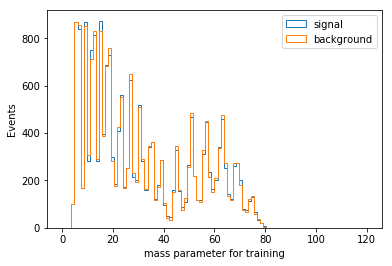

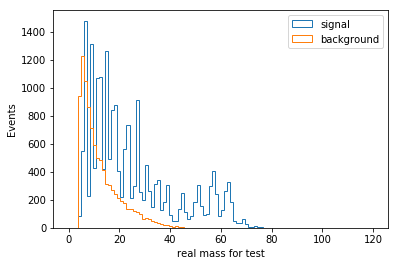

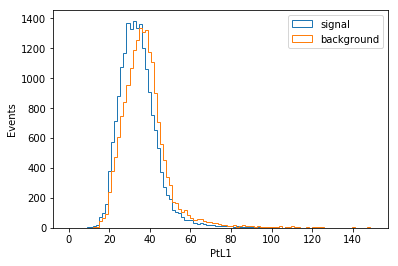

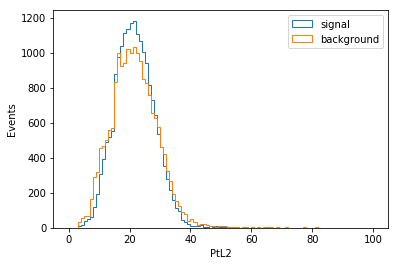

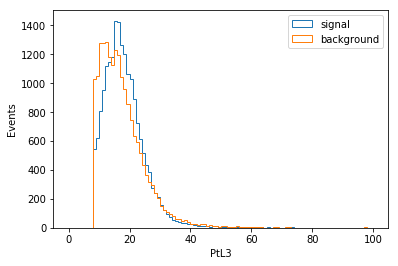

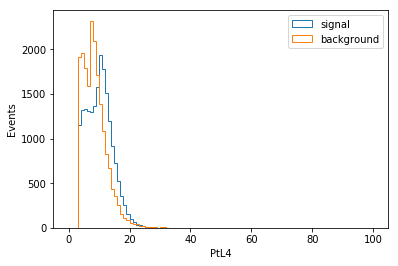

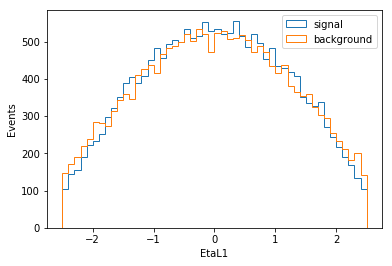

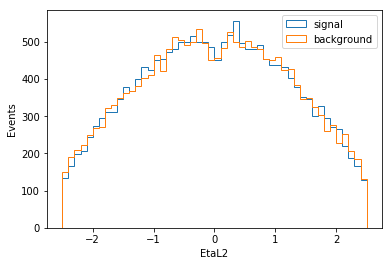

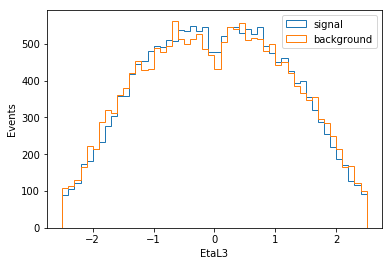

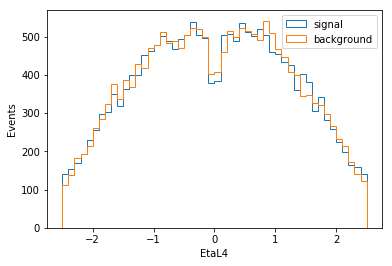

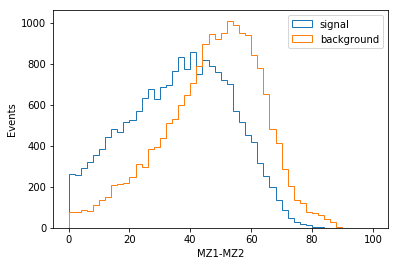

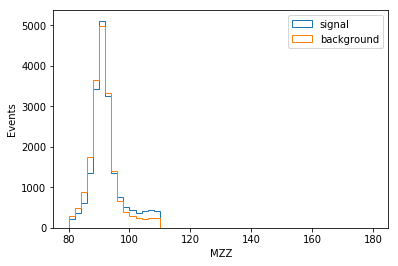

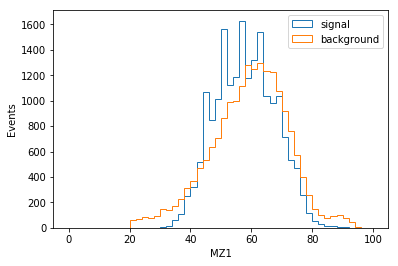

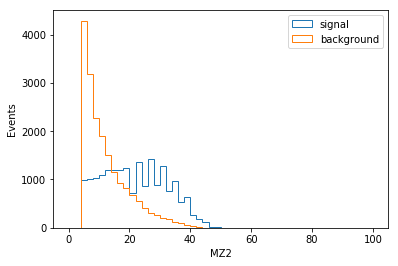

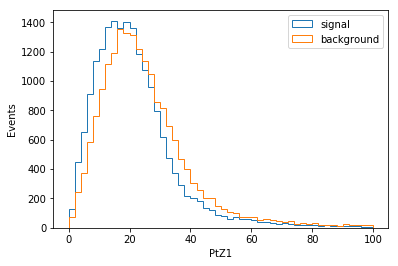

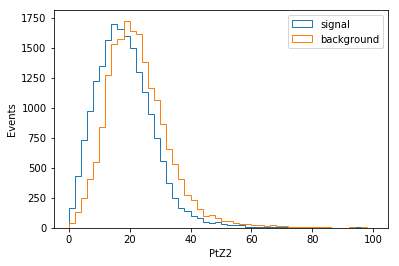

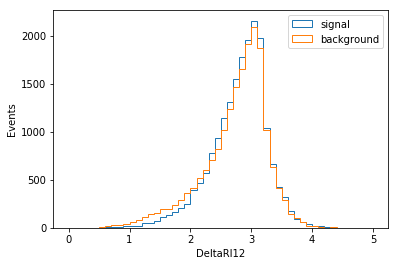

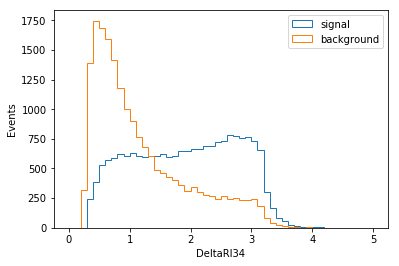

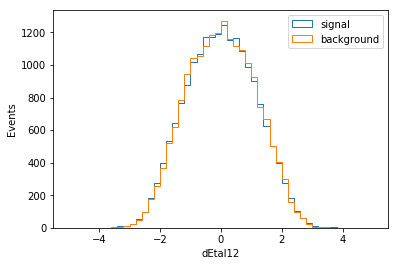

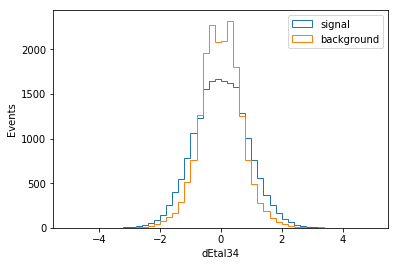

In [6]:
import matplotlib.pyplot as plt
'''
plt.hist(xs_train[:,0], bins=100, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,1))
plt.hist(xb_train[:,0], bins=100, weights=xb_train[:,-1], histtype='step', label='background', range=(0,1))
plt.legend(prop={'size': 10})
plt.xlabel("mass parameter for training")
plt.ylabel("Events")
#plt.savefig("plots/mass_train.pdf", format='pdf')
plt.show()

plt.hist(xs_test[:,0], bins=100, weights=xs_test[:,-1], histtype='step', label='signal', range=(0,1))
plt.hist(xb_test[:,0], bins=100, weights=xb_test[:,-1], histtype='step', label='background', range=(0,1))
plt.legend(prop={'size': 10})
plt.xlabel("real mass for test")
plt.ylabel("Events")
#plt.savefig("plots/mass_real.pdf")
plt.show()

## PtL1/2/3/4
plt.hist(xs_train[:,1], bins=100, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,1))
plt.hist(xb_train[:,1], bins=100, weights=xb_train[:,-1], histtype='step', label='background', range=(0,1))
plt.legend(prop={'size': 10})
plt.xlabel("PtL1")
plt.ylabel("Events")
#plt.savefig("plots/PtL1.pdf")
plt.show()

plt.hist(xs_train[:,2], bins=100, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,1))
plt.hist(xb_train[:,2], bins=100, weights=xb_train[:,-1], histtype='step', label='background', range=(0,1))
plt.legend(prop={'size': 10})
plt.xlabel("PtL2")
plt.ylabel("Events")
#plt.savefig("plots/PtL2.pdf")
plt.show()

plt.hist(xs_train[:,3], bins=100, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,1))
plt.hist(xb_train[:,3], bins=100, weights=xb_train[:,-1], histtype='step', label='background', range=(0,1))
plt.legend(prop={'size': 10})
plt.xlabel("PtL3")
plt.ylabel("Events")
#plt.savefig("plots/PtL3.pdf")
plt.show()

plt.hist(xs_train[:,4], bins=100, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,1))
plt.hist(xb_train[:,4], bins=100, weights=xb_train[:,-1], histtype='step', label='background', range=(0,1))
plt.legend(prop={'size': 10})
plt.xlabel("PtL4")
plt.ylabel("Events")
#plt.savefig("plots/PtL4.pdf")
plt.show()

## EtaL1/2/3/4
plt.hist(xs_train[:,5], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,1))
plt.hist(xb_train[:,5], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,1))
plt.legend(prop={'size': 10})
plt.xlabel("EtaL1")
plt.ylabel("Events")
#plt.savefig("plots/EtaL1.pdf")
plt.show()

plt.hist(xs_train[:,6], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,1))
plt.hist(xb_train[:,6], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,1))
plt.legend(prop={'size': 10})
plt.xlabel("EtaL2")
plt.ylabel("Events")
#plt.savefig("plots/EtaL2.pdf")
plt.show()

plt.hist(xs_train[:,7], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,1))
plt.hist(xb_train[:,7], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,1))
plt.legend(prop={'size': 10})
plt.xlabel("EtaL3")
plt.ylabel("Events")
#plt.savefig("plots/EtaL3.pdf")
plt.show()

plt.hist(xs_train[:,8], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,1))
plt.hist(xb_train[:,8], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,1))
plt.legend(prop={'size': 10})
plt.xlabel("EtaL4")
plt.ylabel("Events")
#plt.savefig("plots/EtaL4.pdf")
plt.show()

## MZ1-MZ2
plt.hist(xs_train[:,11], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,1))
plt.hist(xb_train[:,11], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,1))
plt.legend(prop={'size': 10})
plt.xlabel("MZ1-MZ2")
plt.ylabel("Events")
#plt.savefig("plots/MZ1_MZ2.pdf")
plt.show()

## MZZ
plt.hist(xs_train[:,14], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,1))
plt.hist(xb_train[:,14], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,1))
plt.legend(prop={'size': 10})
plt.xlabel("MZZ")
plt.ylabel("Events")
#plt.savefig("plots/MZZ.pdf")
plt.show()

## MZ1
plt.hist(xs_train[:,12], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,1))
plt.hist(xb_train[:,12], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,1))
plt.legend(prop={'size': 10})
plt.xlabel("MZ1")
plt.ylabel("Events")
#plt.savefig("plots/MZ1.pdf")
plt.show()

## MZ2
plt.hist(xs_train[:,13], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,1))
plt.hist(xb_train[:,13], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,1))
plt.legend(prop={'size': 10})
plt.xlabel("MZ2")
plt.ylabel("Events")
#plt.savefig("plots/MZ2.pdf")
plt.show()

## PtZ1
plt.hist(xs_train[:,14], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,1))
plt.hist(xb_train[:,14], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,1))
plt.legend(prop={'size': 10})
plt.xlabel("PtZ1")
plt.ylabel("Events")
#plt.savefig("plots/PtZ1.pdf")
plt.show()

## PtZ2
plt.hist(xs_train[:,15], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,1))
plt.hist(xb_train[:,15], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,1))
plt.legend(prop={'size': 10})
plt.xlabel("PtZ2")
plt.ylabel("Events")
#plt.savefig("plots/PtZ2.pdf")
plt.show()

## DeltaRl12/34
plt.hist(xs_train[:,16], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,1))
plt.hist(xb_train[:,16], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,1))
plt.legend(prop={'size': 10})
plt.xlabel("DeltaRl12")
plt.ylabel("Events")
#plt.savefig("plots/DeltaRl12.pdf")
plt.show()

plt.hist(xs_train[:,17], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,1))
plt.hist(xb_train[:,17], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,1))
plt.legend(prop={'size': 10})
plt.xlabel("DeltaRl34")
plt.ylabel("Events")
#plt.savefig("plots/DeltaRl34.pdf")
plt.show()

## dEtal12/34
plt.hist(xs_train[:,18], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,1))
plt.hist(xb_train[:,18], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,1))
plt.legend(prop={'size': 10})
plt.xlabel("dEtal12")
plt.ylabel("Events")
#plt.savefig("plots/dEtal12.pdf")
plt.show()

plt.hist(xs_train[:,19], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,1))
plt.hist(xb_train[:,19], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,1))
plt.legend(prop={'size': 10})
plt.xlabel("dEtal34")
plt.ylabel("Events")
#plt.savefig("plots/dEtal34.pdf")
plt.show()
'''
###################################################################
### plot the real variables before scale
######################################################################
plt.hist(xs_train[:,0], bins=100, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,120))
plt.hist(xb_train[:,0], bins=100, weights=xb_train[:,-1], histtype='step', label='background', range=(0,120))
plt.legend(prop={'size': 10})
plt.xlabel("mass parameter for training")
plt.ylabel("Events")
#plt.savefig("plots/mass_train.pdf", format='pdf')
plt.show()

plt.hist(xs_test[:,0], bins=100, weights=xs_test[:,-1], histtype='step', label='signal', range=(0,120))
plt.hist(xb_test[:,0], bins=100, weights=xb_test[:,-1], histtype='step', label='background', range=(0,120))
plt.legend(prop={'size': 10})
plt.xlabel("real mass for test")
plt.ylabel("Events")
#plt.savefig("plots/mass_real.pdf")
plt.show()

## PtL1/2/3/4
plt.hist(xs_train[:,1], bins=100, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,150))
plt.hist(xb_train[:,1], bins=100, weights=xb_train[:,-1], histtype='step', label='background', range=(0,150))
plt.legend(prop={'size': 10})
plt.xlabel("PtL1")
plt.ylabel("Events")
#plt.savefig("plots/PtL1.pdf")
plt.show()

plt.hist(xs_train[:,2], bins=100, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,100))
plt.hist(xb_train[:,2], bins=100, weights=xb_train[:,-1], histtype='step', label='background', range=(0,100))
plt.legend(prop={'size': 10})
plt.xlabel("PtL2")
plt.ylabel("Events")
#plt.savefig("plots/PtL2.pdf")
plt.show()

plt.hist(xs_train[:,3], bins=100, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,100))
plt.hist(xb_train[:,3], bins=100, weights=xb_train[:,-1], histtype='step', label='background', range=(0,100))
plt.legend(prop={'size': 10})
plt.xlabel("PtL3")
plt.ylabel("Events")
#plt.savefig("plots/PtL3.pdf")
plt.show()

plt.hist(xs_train[:,4], bins=100, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,100))
plt.hist(xb_train[:,4], bins=100, weights=xb_train[:,-1], histtype='step', label='background', range=(0,100))
plt.legend(prop={'size': 10})
plt.xlabel("PtL4")
plt.ylabel("Events")
#plt.savefig("plots/PtL4.pdf")
plt.show()

## EtaL1/2/3/4
plt.hist(xs_train[:,5], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(-2.5,2.5))
plt.hist(xb_train[:,5], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(-2.5,2.5))
plt.legend(prop={'size': 10})
plt.xlabel("EtaL1")
plt.ylabel("Events")
#plt.savefig("plots/EtaL1.pdf")
plt.show()

plt.hist(xs_train[:,6], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(-2.5,2.5))
plt.hist(xb_train[:,6], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(-2.5,2.5))
plt.legend(prop={'size': 10})
plt.xlabel("EtaL2")
plt.ylabel("Events")
#plt.savefig("plots/EtaL2.pdf")
plt.show()

plt.hist(xs_train[:,7], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(-2.5,2.5))
plt.hist(xb_train[:,7], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(-2.5,2.5))
plt.legend(prop={'size': 10})
plt.xlabel("EtaL3")
plt.ylabel("Events")
#plt.savefig("plots/EtaL3.pdf")
plt.show()

plt.hist(xs_train[:,8], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(-2.5,2.5))
plt.hist(xb_train[:,8], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(-2.5,2.5))
plt.legend(prop={'size': 10})
plt.xlabel("EtaL4")
plt.ylabel("Events")
#plt.savefig("plots/EtaL4.pdf")
plt.show()

## MZ1-MZ2
plt.hist(xs_train[:,11], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,100))
plt.hist(xb_train[:,11], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,100))
plt.legend(prop={'size': 10})
plt.xlabel("MZ1-MZ2")
plt.ylabel("Events")
#plt.savefig("plots/MZ1_MZ2.pdf")
plt.show()

## MZZ
plt.hist(xs_train[:,14], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(80,180))
plt.hist(xb_train[:,14], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(80,180))
plt.legend(prop={'size': 10})
plt.xlabel("MZZ")
plt.ylabel("Events")
#plt.savefig("plots/MZZ.pdf")
plt.show()

## MZ1
plt.hist(xs_train[:,9], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,100))
plt.hist(xb_train[:,9], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,100))
plt.legend(prop={'size': 10})
plt.xlabel("MZ1")
plt.ylabel("Events")
#plt.savefig("plots/MZ1.pdf")
plt.show()

## MZ2
plt.hist(xs_train[:,10], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,100))
plt.hist(xb_train[:,10], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,100))
plt.legend(prop={'size': 10})
plt.xlabel("MZ2")
plt.ylabel("Events")
#plt.savefig("plots/MZ2.pdf")
plt.show()

## PtZ1
plt.hist(xs_train[:,12], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,100))
plt.hist(xb_train[:,12], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,100))
plt.legend(prop={'size': 10})
plt.xlabel("PtZ1")
plt.ylabel("Events")
#plt.savefig("plots/PtZ1.pdf")
plt.show()

## PtZ2
plt.hist(xs_train[:,13], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,100))
plt.hist(xb_train[:,13], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,100))
plt.legend(prop={'size': 10})
plt.xlabel("PtZ2")
plt.ylabel("Events")
#plt.savefig("plots/PtZ2.pdf")
plt.show()

## DeltaRl12/34
plt.hist(xs_train[:,16], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,5))
plt.hist(xb_train[:,16], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,5))
plt.legend(prop={'size': 10})
plt.xlabel("DeltaRl12")
plt.ylabel("Events")
#plt.savefig("plots/DeltaRl12.pdf")
plt.show()

plt.hist(xs_train[:,17], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(0,5))
plt.hist(xb_train[:,17], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(0,5))
plt.legend(prop={'size': 10})
plt.xlabel("DeltaRl34")
plt.ylabel("Events")
#plt.savefig("plots/DeltaRl34.pdf")
plt.show()

## dEtal12/34
plt.hist(xs_train[:,18], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(-5,5))
plt.hist(xb_train[:,18], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(-5,5))
plt.legend(prop={'size': 10})
plt.xlabel("dEtal12")
plt.ylabel("Events")
#plt.savefig("plots/dEtal12.pdf")
plt.show()

plt.hist(xs_train[:,19], bins=50, weights=xs_train[:,-1], histtype='step', label='signal', range=(-5,5))
plt.hist(xb_train[:,19], bins=50, weights=xb_train[:,-1], histtype='step', label='background', range=(-5,5))
plt.legend(prop={'size': 10})
plt.xlabel("dEtal34")
plt.ylabel("Events")
#plt.savefig("plots/dEtal34.pdf")
plt.show()



# Setting training

In [10]:
# "Deep" neural network
model_deep = Sequential()
model_deep.add(Dense(300, kernel_initializer="glorot_normal", activation="relu",
    input_dim=xcomb_train.shape[1]))
model_deep.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
model_deep.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
model_deep.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
model_deep.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
model_deep.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))

# Set loss, optimizer and evaluation metrics
model_deep.compile(
     loss="binary_crossentropy",
     optimizer=SGD(decay=1e-6),
     metrics=["accuracy"])

# Train
model_deep.fit(xcomb_train,
           ycomb_train,
           batch_size=100,
           epochs=15,
           validation_data=(xcomb_val, ycomb_val, wt_val),
           sample_weight=wt_train)

score = model_deep.evaluate(xcomb_test, ycomb_test, verbose=0, sample_weight=wt_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Save models
model_deep.save("Below120/models/SGD/lowM_18features.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 76294 samples, validate on 25434 samples
Epoch 1/15
76294/76294 [==============================] - 7s 95us/step - loss: 0.1710 - acc: 0.7497 - val_loss: 0.6179 - val_acc: 0.7020
Epoch 2/15
76294/76294 [==============================] - 7s 95us/step - loss: 0.1367 - acc: 0.8284 - val_loss: 0.6503 - val_acc: 0.7055
Epoch 3/15
76294/76294 [==============================] - 8s 103us/step - loss: 0.1258 - acc: 0.8490 - val_loss: 0.6501 - val_acc: 0.7021
Epoch 4/15
76294/76294 [==============================] - 8s 99us/step - loss: 0.1201 - acc: 0.8574 - val_loss: 0.6665 - val_acc: 0.7038
Epoch 5/15
76294/76294 [==============================] - 7s 98us/step - loss: 0.1169 - acc: 0.8655 - val_loss: 0.6712 - val_acc: 0.7049
Epoch 6/15
76294/76294 [==============================] - 8s 100us/step - loss: 0.1148 - acc: 0.8694 - val_loss: 0.8425 - val_acc: 0.5588
Epoch 

2019-05-15 10:34:17.587465: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


## Plot AUC with different mass signal sample
### compare by reset train_mass to MZ1 or MZ2

No handles with labels found to put in legend.


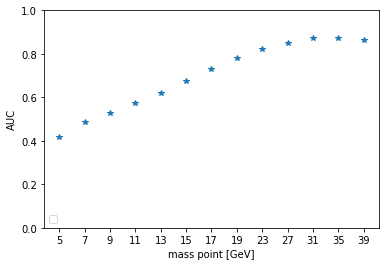

In [11]:
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.models import load_model

model = load_model("Below120/models/SGD/lowM_18features.h5")

## load test (cross validation) data
xb_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below120/UnscaledData/test/tree_bkg.npy')
yb_test = np.zeros(len(xb_test))

#msamp = [5,7,9,11,13,15,17,19,23,27,31,35,39,45,51,57,63,69,75]
msamp = [5,7,9,11,13,15,17,19,23,27,31,35,39]
auc_dm = np.zeros(len(msamp))

for im,mass in enumerate(msamp):
    if mass < 40: nZp = 10
    elif mass > 40: nZp = 9
    xs_test_dm = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below120/UnscaledData/test/tree_{}GeV.npy'.format(mass))
    ys_test_dm = np.ones(len(xs_test_dm))

    xcomb_test_dm = np.concatenate((xs_test_dm, xb_test)) 
    ycomb_test_dm = np.concatenate((ys_test_dm, yb_test))
    # Randomlize the order of training data using split function
    x1, xcomb_test_dm, y1, ycomb_test_dm = train_test_split(
        xcomb_test_dm, ycomb_test_dm, test_size=0.999999, random_state=1234, shuffle=True)
    xcomb_test_dm[:,0] = xcomb_test_dm[:,nZp]
    xcomb_test_dm = get_part_feature(xcomb_test_dm)

    predictions_dm = model.predict(xcomb_test_dm)
    # Compare to ground truth and create ROC plot
    fpr_dm, tpr_dm, _ = roc_curve(ycomb_test_dm, predictions_dm)
    if mass == 31:
        fpr_31 = fpr_dm
        tpr_31 = tpr_dm
    auc_dm[im] = auc(fpr_dm, tpr_dm)        
    
# Plot AUC
plt.figure(figsize=(6, 4))
plt.plot(auc_dm, '*')
plt.xticks(np.arange(13), msamp)
plt.ylim((0,1))
plt.xlabel("mass point [GeV]")
plt.ylabel("AUC")
plt.legend(loc=3)
plt.show()

### results for training w/o one mass point

In [18]:
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.models import load_model

model = load_model("Below120/models/SGD/baseline_18features_no69GeV.h5")

## load test (cross validation) data
xb_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below120/UnscaledData/test/tree_bkg.npy')
yb_test = np.zeros(len(xb_test))

msamp = [5,7,9,11,13,15,17,19,23,27,31,35,39,45,51,57,63,69,75]
auc_dm_no31 = np.zeros(len(msamp))

for im,mass in enumerate(msamp):
    if mass < 40: nZp = 10
    elif mass > 40: nZp = 9
    #print("Test mass sample: ", mass, "GeV")
    xs_test_dm = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below120/UnscaledData/test/tree_{}GeV.npy'.format(mass))
    ys_test_dm = np.ones(len(xs_test_dm))

    xcomb_test_dm = np.concatenate((xs_test_dm, xb_test)) 
    ycomb_test_dm = np.concatenate((ys_test_dm, yb_test))
    #xcomb_test_dm = xs_test_dm
    #ycomb_test_dm = ys_test_dm
    # Randomlize the order of training data using split function
    x1, xcomb_test_dm, y1, ycomb_test_dm = train_test_split(
        xcomb_test_dm, ycomb_test_dm, test_size=0.999999, random_state=1234, shuffle=True)
    xcomb_test_dm[:,0] = xcomb_test_dm[:,nZp]
    xcomb_test_dm = get_part_feature(xcomb_test_dm)

    predictions_dm = model.predict(xcomb_test_dm)
    # Compare to ground truth and create ROC plot
    fpr_dm, tpr_dm, _ = roc_curve(ycomb_test_dm, predictions_dm)
    if mass == 31:
        fpr_31_no31 = fpr_dm
        tpr_31_no31 = tpr_dm
    auc_dm_no31[im] = auc(fpr_dm, tpr_dm)
    #print(auc_dm[im])

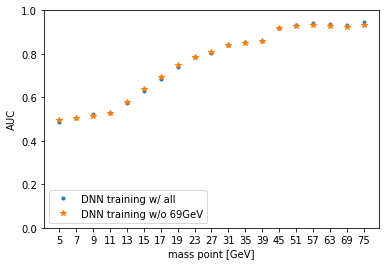

In [19]:
# Plot AUC
plt.figure(figsize=(6, 4))
plt.plot(auc_dm, '.', label='DNN training w/ all')
plt.plot(auc_dm_no31, '*', label='DNN training w/o 69GeV')
plt.xticks(np.arange(19), msamp)
plt.ylim((0,1))
plt.xlabel("mass point [GeV]")
plt.ylabel("AUC")
plt.legend(loc=3)
plt.show()

NameError: name 'tpr_31_no31' is not defined

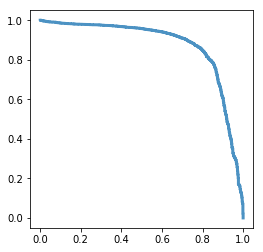

In [12]:
# Plot ROC
plt.figure(figsize=(4, 4))
plt.plot(tpr_31, 1.0-fpr_31, lw=3, alpha=0.8,
        label="Train all samples (AUC={:.2f})".format(auc_dm[10]))
plt.plot(tpr_31_no31, 1.0-fpr_31_no31, lw=3, alpha=0.8,
        label="Train w/o 31GeV (AUC={:.2f})".format(auc_dm_no31[10]))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")
plt.legend(loc=3)
plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))
plt.show()

# Now let's test the signal and bkg to get the score one by one
## For signal and background prediction separately
## Firstly need to check if over-fitting

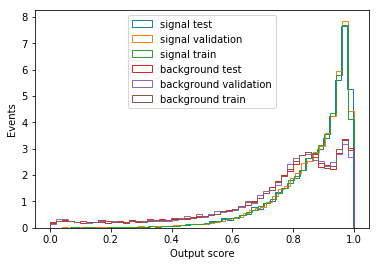

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.models import load_model

model = load_model("Below180/models/SGD/baseline_18features.h5")
nZp=10

### prepare prediction for signal
xs_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_{}GeV.npy'.format(5))
xs_val = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/Validation/tree_{}GeV.npy'.format(5))
xs_train = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/train/tree_{}GeV.npy'.format(5))
#msamp = [7,9,11,13,15,17,19,23,27,31,35,39,45,51,57,63,69,75]
msamp = [7,9,11,13,15,17,19,23,27,31,35,39]
for mass in msamp:
    xs_test_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_{}GeV.npy'.format(mass))
    xs_test = np.concatenate((xs_test, xs_test_add))
    xs_val_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/Validation/tree_{}GeV.npy'.format(mass))
    xs_val = np.concatenate((xs_val, xs_val_add))
    xs_train_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/train/tree_{}GeV.npy'.format(mass))
    xs_train = np.concatenate((xs_train, xs_train_add))
    
xs_test[:,0] = xs_test[:,nZp]
xs_test_par = get_part_feature(xs_test)
pred_sig_test = model.predict(xs_test_par)
xs_val[:,0] = xs_val[:,nZp]
xs_val_par = get_part_feature(xs_val)
pred_sig_val = model.predict(xs_val_par)
xs_train[:,0] = xs_train[:,nZp]
xs_train_par = get_part_feature(xs_train)
pred_sig_train = model.predict(xs_train_par)

### prepare prediction for background test sample
xb_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_bkg.npy')
xb_test[:,0] = xb_test[:,nZp]
xb_test_par = get_part_feature(xb_test)
pred_bkg_test = model.predict(xb_test_par)

### prepare prediction for background Validation sample
xb_val = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/Validation/tree_bkg.npy')
xb_val[:,0] = xb_val[:,nZp]
xb_val_par = get_part_feature(xb_val)
pred_bkg_val = model.predict(xb_val_par)

### prepare prediction for background test sample
xb_train = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/train/tree_bkg.npy')
xb_train[:,0] = xb_train[:,nZp]
xb_train_par = get_part_feature(xb_train)
pred_bkg_train = model.predict(xb_train_par)

#print(len(pred_sig_test), len(xs_test), sum(xs_test[:,-1]))
#print(len(pred_bkg_test), len(xb_test), sum(xb_test[:,-1]))
#print(len(pred_bkg_val), len(xb_val), sum(xb_val[:,-1]))

## plot output score
plt.hist(pred_sig_test, bins=50, histtype='step', label='signal test', density=True)
plt.hist(pred_sig_val, bins=50, histtype='step', label='signal validation', density=True)
plt.hist(pred_sig_train, bins=50, histtype='step', label='signal train', density=True)
plt.hist(pred_bkg_test, bins=50, histtype='step', label='background test', density=True)
plt.hist(pred_bkg_val, bins=50, histtype='step', label='background validation', density=True)
plt.hist(pred_bkg_train, bins=50, histtype='step', label='background train', density=True)
plt.legend(loc=9)
plt.xlabel("Output score")
plt.ylabel("Events")
plt.show()

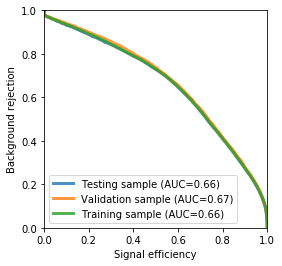

In [14]:
xcomb_test2 = np.concatenate((xs_test_par,xb_test_par))
xcomb_val2 = np.concatenate((xs_val_par,xb_val_par))
xcomb_train2 = np.concatenate((xs_train_par,xb_train_par))

ys_test2 = np.ones(len(xs_test_par))
ys_val2 = np.ones(len(xs_val_par))
ys_train2 = np.ones(len(xs_train_par))
yb_test2 = np.zeros(len(xb_test_par))
yb_val2 = np.zeros(len(xb_val_par))
yb_train2 = np.zeros(len(xb_train_par))
ycomb_test2 = np.concatenate((ys_test2,yb_test2))
ycomb_val2 = np.concatenate((ys_val2,yb_val2))
ycomb_train2 = np.concatenate((ys_train2,yb_train2))

pred_test = np.concatenate((pred_sig_test,pred_bkg_test))
pred_val = np.concatenate((pred_sig_val,pred_bkg_val))
pred_train = np.concatenate((pred_sig_train,pred_bkg_train))

# Compare to ground truth and create ROC plot
fpr_test, tpr_test, _ = roc_curve(ycomb_test2, pred_test)
auc_test = auc(fpr_test, tpr_test)
fpr_val, tpr_val, _ = roc_curve(ycomb_val2, pred_val)
auc_val = auc(fpr_val, tpr_val)
fpr_train, tpr_train, _ = roc_curve(ycomb_train2, pred_train)
auc_train = auc(fpr_train, tpr_train)

# Plot ROC
plt.figure(figsize=(4, 4))
plt.plot(tpr_test, 1.0-fpr_test, lw=3, alpha=0.8,
        label="Testing sample (AUC={:.2f})".format(auc_test))
plt.plot(tpr_val, 1.0-fpr_val, lw=3, alpha=0.8,
        label="Validation sample (AUC={:.2f})".format(auc_val))
plt.plot(tpr_train, 1.0-fpr_train, lw=3, alpha=0.8,
        label="Training sample (AUC={:.2f})".format(auc_train))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")
plt.legend(loc=3)
plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))
plt.show()

If cut at score >  0.5
Signal efficiency:  0.9588829133712888
Background efficiency:  0.8500931656619425
Significance BEFORE: S/sqrt(B)  1
Significance AFTER: S/sqrt(B)  1.0399975531926005


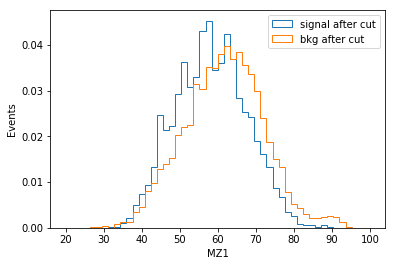

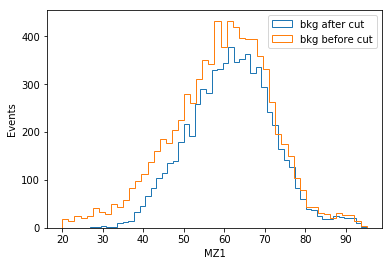

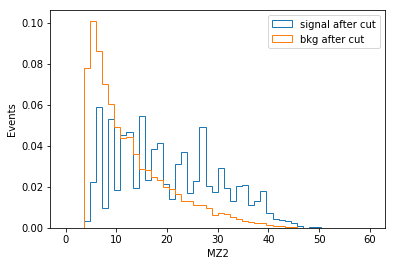

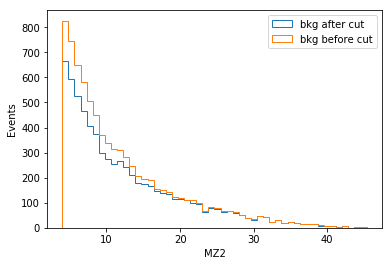

In [12]:
cut = 0.5
print ("If cut at score > ", cut)
## Before cut
all_sig_all=0
all_bkg_all=0
for ie in range(len(xs_test)):
    all_sig_all += xs_test[ie,-1]

for ie in range(len(xb_test)):
    all_bkg_all += xb_test[ie,-1]

sigif_all = all_sig_all/np.sqrt(all_bkg_all)

print ("===========================")

## After cut
n_sig = 0
n_bkg = 0
xs_good = np.empty((0,xs_test.shape[1]))
for ie in range(len(xs_test)):
    if pred_sig_test[ie]>cut:
        n_sig += xs_test[ie,-1]
        xs_good = np.append(xs_good, np.reshape(xs_test[ie],(1,-1)),axis = 0)

xb_good = np.empty((0,xb_test.shape[1]))
for ie in range(len(xb_test)):
    if pred_bkg_test[ie]>cut:
        n_bkg += xb_test[ie,-1]
        xb_good = np.append(xb_good, np.reshape(xb_test[ie],(1,-1)),axis = 0)
#print (len(xb_good))
        
eff_sig = n_sig/all_sig_all
eff_bkg = n_bkg/all_bkg_all
sigif_cut = eff_sig/np.sqrt(eff_bkg)

print ("Signal efficiency: ", eff_sig)
print ("Background efficiency: ", eff_bkg)
print ("Significance BEFORE: S/sqrt(B) ", 1)
print ("Significance AFTER: S/sqrt(B) ", sigif_cut)

## make plots after cut
plt.hist(xs_good[:,9], bins=50, histtype='step', label='signal after cut', range=(20,100), density=True)
plt.hist(xb_good[:,9], bins=50, histtype='step', label='bkg after cut', range=(20,100), density=True)
#plt.hist(xs_test[:,9], bins=50, histtype='step', label='signal before cut')
plt.legend(prop={'size': 10})
plt.xlabel("MZ1")
plt.ylabel("A.U.")
plt.show()

plt.hist(xb_good[:,9], bins=50, histtype='step', label='bkg after cut')
plt.hist(xb_test[:,9], bins=50, histtype='step', label='bkg before cut')
plt.legend(prop={'size': 10})
plt.xlabel("MZ1")
plt.ylabel("Events")
plt.show()

plt.hist(xs_good[:,10], bins=50, histtype='step', label='signal after cut', range=(0,60), density=True)
plt.hist(xb_good[:,10], bins=50, histtype='step', label='bkg after cut', range=(0,60), density=True)
#plt.hist(xs_test[:,10], bins=50, histtype='step', label='signal before cut')
plt.legend(prop={'size': 10})
plt.xlabel("MZ2")
plt.ylabel("A.U.")
plt.show()

plt.hist(xb_good[:,10], bins=50, histtype='step', label='bkg after cut')
plt.hist(xb_test[:,10], bins=50, histtype='step', label='bkg before cut')
plt.legend(prop={'size': 10})
plt.xlabel("MZ2")
plt.ylabel("Events")
plt.show()

## Check one mass point each time

Looking at mass:  5 GeV; 5sigma:  0.375572


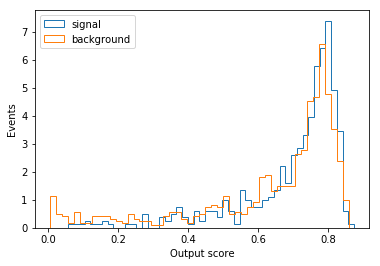

/Users/zhuheling/ML/venv/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


Best cut  0.25
Signal efficiency:  0.9764549711829642
Background efficiency:  0.9010714028913641
Significance BEFORE: S/sqrt(B)  1.0
Significance AFTER: S/sqrt(B)  1.0286618119367499
Looking at mass:  7 GeV; 5sigma:  0.5663940000000001


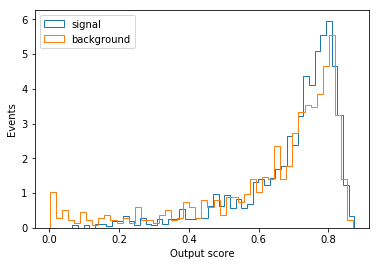

Best cut  0.2
Signal efficiency:  0.9886953965918516
Background efficiency:  0.9327709844479637
Significance BEFORE: S/sqrt(B)  1.0
Significance AFTER: S/sqrt(B)  1.023705409053978
Looking at mass:  9 GeV; 5sigma:  0.757216


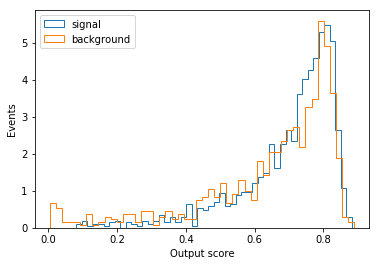

Best cut  0.30000000000000004
Signal efficiency:  0.9759264066538036
Background efficiency:  0.9200357310852516
Significance BEFORE: S/sqrt(B)  1.0
Significance AFTER: S/sqrt(B)  1.0174538564173614
Looking at mass:  11 GeV; 5sigma:  0.948038


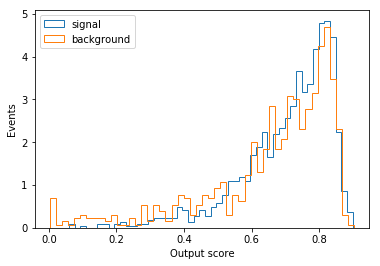

Best cut  0.30000000000000004
Signal efficiency:  0.9843309929276939
Background efficiency:  0.9269131904239309
Significance BEFORE: S/sqrt(B)  1.0
Significance AFTER: S/sqrt(B)  1.0224018541765925
Looking at mass:  13 GeV; 5sigma:  1.13886


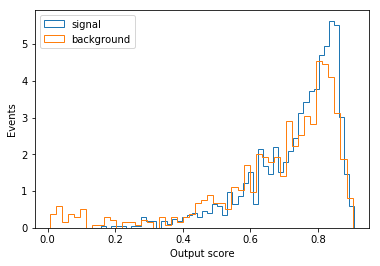

Best cut  0.25
Signal efficiency:  0.9964062860091065
Background efficiency:  0.9408655209371208
Significance BEFORE: S/sqrt(B)  1.0
Significance AFTER: S/sqrt(B)  1.0272417969585803
Looking at mass:  15 GeV; 5sigma:  1.329682


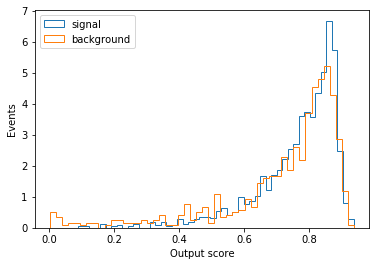

Best cut  0.45
Signal efficiency:  0.9713822933160225
Background efficiency:  0.9031452653305866
Significance BEFORE: S/sqrt(B)  1.0
Significance AFTER: S/sqrt(B)  1.0221423391329645
Looking at mass:  17 GeV; 5sigma:  1.520504


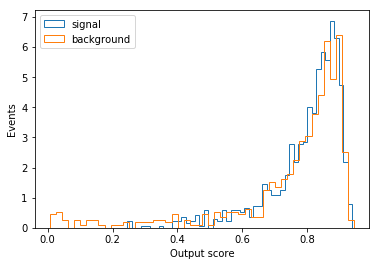

Best cut  0.4
Signal efficiency:  0.9894956984400937
Background efficiency:  0.9242838216721665
Significance BEFORE: S/sqrt(B)  1.0
Significance AFTER: S/sqrt(B)  1.0292271522157272
Looking at mass:  19 GeV; 5sigma:  1.711326


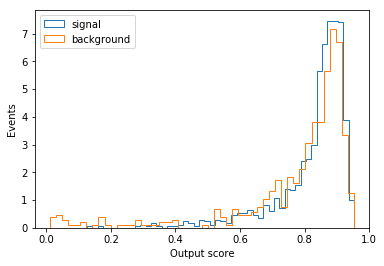

Best cut  0.4
Signal efficiency:  0.9893285831321798
Background efficiency:  0.9289038701528706
Significance BEFORE: S/sqrt(B)  1.0
Significance AFTER: S/sqrt(B)  1.026491058032917
Looking at mass:  23 GeV; 5sigma:  2.09297


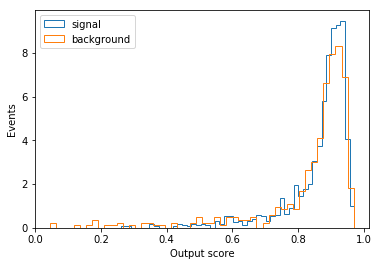

Best cut  0.35000000000000003
Signal efficiency:  0.9984470016810802
Background efficiency:  0.9673049525367623
Significance BEFORE: S/sqrt(B)  1.0
Significance AFTER: S/sqrt(B)  1.01518060380946
Looking at mass:  27 GeV; 5sigma:  2.474614


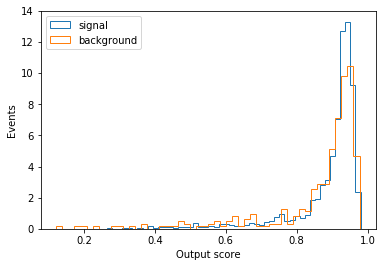

Best cut  0.35000000000000003
Signal efficiency:  0.9970729996299503
Background efficiency:  0.980293704723952
Significance BEFORE: S/sqrt(B)  1.0
Significance AFTER: S/sqrt(B)  1.0070449339575938
Looking at mass:  31 GeV; 5sigma:  2.856258


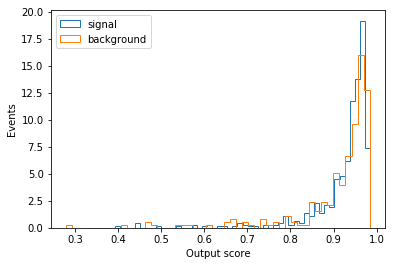

Best cut  0.30000000000000004
Signal efficiency:  1.0
Background efficiency:  0.9959388784135845
Significance BEFORE: S/sqrt(B)  1.0
Significance AFTER: S/sqrt(B)  1.0020367665644652
Looking at mass:  35 GeV; 5sigma:  3.237902


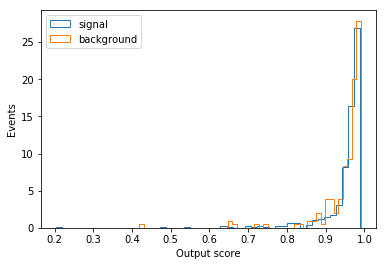

Best cut  0.45
Signal efficiency:  0.9979802144659247
Background efficiency:  0.993265688898104
Significance BEFORE: S/sqrt(B)  1.0
Significance AFTER: S/sqrt(B)  1.0013576371515682
Looking at mass:  39 GeV; 5sigma:  3.619546


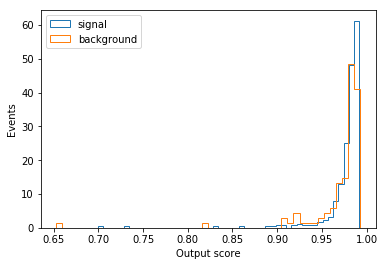

Best cut  0.9500000000000001
Signal efficiency:  0.945262016853111
Background efficiency:  0.8584133385663187
Significance BEFORE: S/sqrt(B)  1.0
Significance AFTER: S/sqrt(B)  1.0202438333682964
Looking at mass:  45 GeV; 5sigma:  4.192012


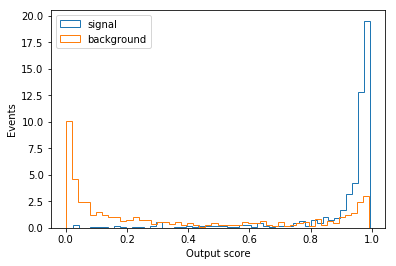

Best cut  0.9
Signal efficiency:  0.7999690983651238
Background efficiency:  0.16623298103678172
Significance BEFORE: S/sqrt(B)  1.0
Significance AFTER: S/sqrt(B)  1.962070529179464
Looking at mass:  51 GeV; 5sigma:  4.764478


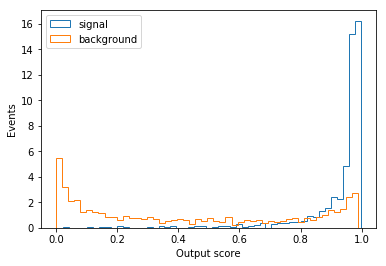

Best cut  0.9500000000000001
Signal efficiency:  0.6581770808599067
Background efficiency:  0.09901716554581555
Significance BEFORE: S/sqrt(B)  1.0
Significance AFTER: S/sqrt(B)  2.091642752565253
Looking at mass:  57 GeV; 5sigma:  5.336944


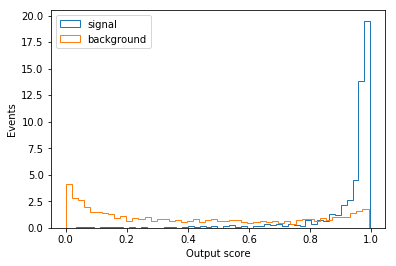

Best cut  0.9500000000000001
Signal efficiency:  0.6810718891862102
Background efficiency:  0.070404790701622
Significance BEFORE: S/sqrt(B)  1.0
Significance AFTER: S/sqrt(B)  2.566798929770326
Looking at mass:  63 GeV; 5sigma:  5.90941


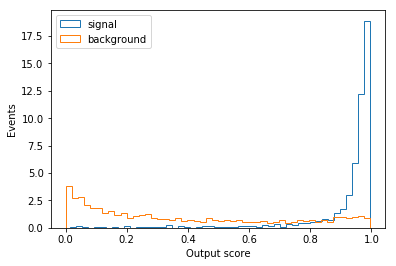

Best cut  0.9500000000000001
Signal efficiency:  0.661733006004236
Background efficiency:  0.047139311904967784
Significance BEFORE: S/sqrt(B)  1.0
Significance AFTER: S/sqrt(B)  3.0478330741293704
Looking at mass:  69 GeV; 5sigma:  6.481876


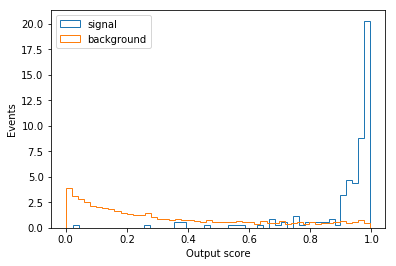

Best cut  0.9500000000000001
Signal efficiency:  0.5946057437508804
Background efficiency:  0.028146165744533734
Significance BEFORE: S/sqrt(B)  1.0
Significance AFTER: S/sqrt(B)  3.5442102699527256
Looking at mass:  75 GeV; 5sigma:  7.054342


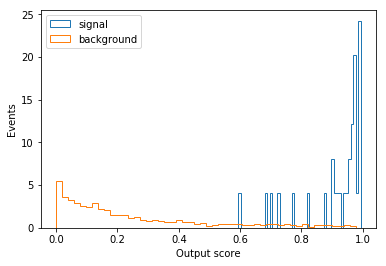

Best cut  0.9
Signal efficiency:  0.7272833611444249
Background efficiency:  0.019570367848820325
Significance BEFORE: S/sqrt(B)  1.0
Significance AFTER: S/sqrt(B)  5.1988125354378685


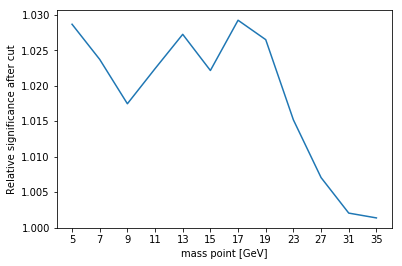

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.models import load_model

model = load_model("Below120/models/SGD/baseline_18features.h5")

### prepare prediction for signal
#xs_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below120/scaledData/test/tree_{}GeV.npy'.format(massp))
msamp = [5,7,9,11,13,15,17,19,23,27,31,35,39,45,51,57,63,69,75]
#msamp = [5,7,9,11,13,15,17,19,23,27,31,35,39]
sigif = np.ones(len(msamp))
i=0
for mass in msamp:
    print ("=====================================")
    if mass < 40.: nZp = 10
    elif mass > 40.: nZp = 9
    sigma = 5*(-0.0202966+0.0190822*mass)
    print ("Looking at mass: ", mass, "GeV; 5sigma: ", sigma)    
    xs_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below120/UnscaledData/test/tree_{}GeV.npy'.format(mass))
    xs_test[:,0] = xs_test[:,nZp]
    ### prepare prediction for background test sample
    xb_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below120/UnscaledData/test/tree_bkg.npy')
    xb_test[:,0] = xb_test[:,nZp]

    ## Before cut
    all_sig_lM=0
    all_bkg_lM=0
    all_sig=0
    all_bkg=0
    xs_region = np.empty((0,xs_test.shape[1]))
    xb_region = np.empty((0,xb_test.shape[1]))
    for ie in range(len(xs_test)):
        if xs_test[ie,nZp] < mass+sigma and xs_test[ie,nZp] > mass-sigma:
            xs_region = np.append(xs_region, np.reshape(xs_test[ie],(1,-1)),axis = 0)
            all_sig += xs_test[ie,-1]
            if xs_test[ie,14]<120.: all_sig_lM += xs_test[ie,-1]

    for ie in range(len(xb_test)):
        if xb_test[ie,nZp] < mass+sigma and xb_test[ie,nZp] > mass-sigma:
            xb_region = np.append(xb_region, np.reshape(xb_test[ie],(1,-1)),axis = 0)
            all_bkg += xb_test[ie,-1]
            if xb_test[ie,14]<120.: all_bkg_lM += xb_test[ie,-1]

    eff1_sig=all_sig/all_sig_lM
    eff1_bkg=all_bkg/all_bkg_lM
    sigif_all = eff1_sig/np.sqrt(eff1_bkg)
    #print("Events in mass window before DNN cut: signal/bkg", len(xs_region), len(xb_region)
    xs_reg_par = get_part_feature(xs_region)
    pred_sig_reg = model.predict(xs_reg_par)
    xb_reg_par = get_part_feature(xb_region)
    pred_bkg_reg = model.predict(xb_reg_par)

    ## plot output score
    plt.hist(pred_sig_reg, bins=50, histtype='step', label='signal', density=True)
    plt.hist(pred_bkg_reg, bins=50, histtype='step', label='background', density=True)
    plt.legend(loc=2)
    plt.xlabel("Output score")
    plt.ylabel("Events")
    plt.show()
    
    ## After cut
    max_signif = -1.
    ## Do scan of cut
    for ic in range(20):
        cut = ic*0.05
        n_sig = 0
        n_bkg = 0
        for ie in range(len(xs_region)):
            if pred_sig_reg[ie]>cut: n_sig += xs_region[ie,-1]
        for ie in range(len(xb_region)):
            if pred_bkg_reg[ie]>cut: n_bkg += xb_region[ie,-1]

        s_eff = n_sig/all_sig_lM
        b_eff = n_bkg/all_bkg_lM
        sigif_cut = s_eff/np.sqrt(b_eff)
        if sigif_cut > max_signif:
            eff_sig = s_eff
            eff_bkg = b_eff
            max_signif = sigif_cut
            mCut = cut

    print ("Best cut ", mCut)
    print ("Signal efficiency: ", eff_sig)
    print ("Background efficiency: ", eff_bkg)
    print ("Significance BEFORE: S/sqrt(B) ", sigif_all)
    print ("Significance AFTER: S/sqrt(B) ", max_signif)
    
    ## save significance
    sigif[i] = max_signif
    i+=1


## plot significance of each point
plt.plot(sigif[0:12])
plt.xticks(np.arange(12), msamp[0:12])
plt.xlabel("mass point [GeV]")
plt.ylabel("Relative significance after cut")
plt.show()

## Test different signal prediction with different mass point
### 13GeV vs 63GeV

1457 1457 1351.2760822287337
1020 1020 961.6729755058083
8064 8064 9518.544791565975


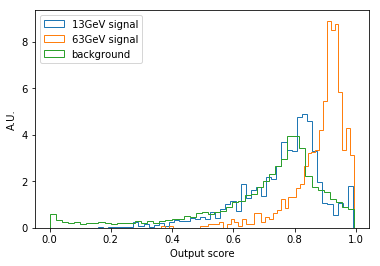

In [30]:
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.models import load_model

model = load_model("Below120/models/SGD/baseline_18features.h5")
nZp=10

### prepare prediction for signals
xs_test_13 = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below120/UnscaledData/test/tree_{}GeV.npy'.format(13))
xs_test_63 = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below120/UnscaledData/test/tree_{}GeV.npy'.format(63))
xs_test_13[:,0] = xs_test_13[:,nZp]
xs_test_63[:,0] = xs_test_63[:,nZp]
xs_test_13_par = get_part_feature(xs_test_13)
xs_test_63_par = get_part_feature(xs_test_63)
pred_signal_13 = model.predict(xs_test_13_par)
pred_signal_63 = model.predict(xs_test_63_par)

### prepare prediction for background
xb_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below120/UnscaledData/test/tree_bkg.npy')
xb_test[:,0] = xb_test[:,nZp]
xb_test_par = get_part_feature(xb_test)
pred_bkg_test = model.predict(xb_test_par)

print(len(pred_signal_13), len(xs_test_13), sum(xs_test_13[:,-1]))
print(len(pred_signal_63), len(xs_test_63), sum(xs_test_63[:,-1]))
print(len(pred_bkg_test), len(xb_test), sum(xb_test[:,-1]))

## output score
plt.hist(pred_signal_13, bins=50, histtype='step', label='13GeV signal', density=True)
plt.hist(pred_signal_63, bins=50, histtype='step', label='63GeV signal', density=True)
plt.hist(pred_bkg_test, bins=50, histtype='step', label='background', density=True)
plt.legend(prop={'size': 10})
plt.xlabel("Output score")
plt.ylabel("A.U.")
plt.show()

# Systematics test
## for signal

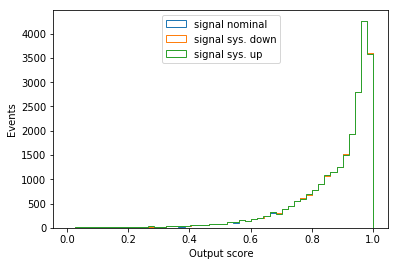

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.models import load_model

model = load_model("Below180/models/SGD/baseline_18features.h5")
nZp=10

### prepare prediction for signal
xs_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_{}GeV.npy'.format(5))
xs_sysdo = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/sysData_down/test/tree_{}GeV.npy'.format(5))
xs_sysup = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/sysData_up/test/tree_{}GeV.npy'.format(5))
msamp = [7,9,11,13,15,17,19,23,27,31,35,39,45,51,57,63,69,75]
for mass in msamp:
    xs_test_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_{}GeV.npy'.format(mass))
    xs_test = np.concatenate((xs_test, xs_test_add))
    xs_sysdo_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/sysData_down/test/tree_{}GeV.npy'.format(mass))
    xs_sysdo = np.concatenate((xs_sysdo, xs_sysdo_add))

    xs_sysup_add = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/sysData_up/test/tree_{}GeV.npy'.format(mass))
    xs_sysup = np.concatenate((xs_sysup, xs_sysup_add))

xs_test[:,0] = xs_test[:,nZp]
xs_test_par = get_part_feature(xs_test)
pred_sig_test = model.predict(xs_test_par)

xs_sysdo[:,0] = xs_sysdo[:,nZp]
xs_sysdo_par = get_part_feature(xs_sysdo)
pred_sig_sysdo = model.predict(xs_sysdo_par)

xs_sysup[:,0] = xs_sysup[:,nZp]
xs_sysup_par = get_part_feature(xs_sysup)
pred_sig_sysup = model.predict(xs_sysup_par)

## plot output score
plt.hist(pred_sig_test, bins=50, histtype='step', label='signal nominal')
plt.hist(pred_sig_sysdo , bins=50, histtype='step', label='signal sys. down')
plt.hist(pred_sig_sysup , bins=50, histtype='step', label='signal sys. up')
plt.legend(loc=9)
plt.xlabel("Output score")
plt.ylabel("Events")
plt.show()

## for background

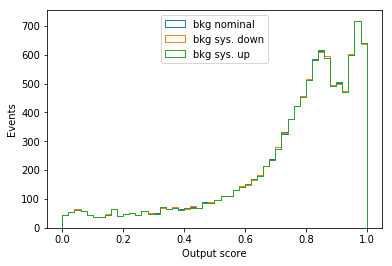

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.models import load_model

model = load_model("Below180/models/SGD/baseline_18features.h5")
nZp=10

### prepare prediction for background test sample
xb_test = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/UnscaledData/test/tree_bkg.npy')
xb_test[:,0] = xb_test[:,nZp]
xb_test_par = get_part_feature(xb_test)
pred_bkg_test = model.predict(xb_test_par)

xb_sysdo = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/sysData_down/test/tree_bkg.npy')
xb_sysdo[:,0] = xb_sysdo[:,nZp]
xb_sysdo_par = get_part_feature(xb_sysdo)
pred_bkg_sysdo = model.predict(xb_sysdo_par)

xb_sysup = np.load('/Users/zhuheling/ML/keras/example_hep/myTest/Below180/sysData_up/test/tree_bkg.npy')
xb_sysup[:,0] = xb_sysup[:,nZp]
xb_sysup_par = get_part_feature(xb_sysup)
pred_bkg_sysup = model.predict(xb_sysup_par)

## plot output score
plt.hist(pred_bkg_test, bins=50, histtype='step', label='bkg nominal')
plt.hist(pred_bkg_sysdo, bins=50, histtype='step', label='bkg sys. down')
plt.hist(pred_bkg_sysup, bins=50, histtype='step', label='bkg sys. up')
plt.legend(loc=9)
plt.xlabel("Output score")
plt.ylabel("Events")
plt.show()